In [11]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
training=pd.read_csv('submission.csv')

In [3]:
data = data.drop(['id', 'CustomerId', 'Surname'], axis=1)
test = test.drop(['id', 'CustomerId', 'Surname'], axis=1)

In [4]:
X = data.drop('Exited', axis=1)
y = data['Exited']

In [5]:
categorical_features = ['Geography', 'Gender']
numerical_features = [col for col in X.columns if col not in categorical_features]
test = test[X.columns]

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), 
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

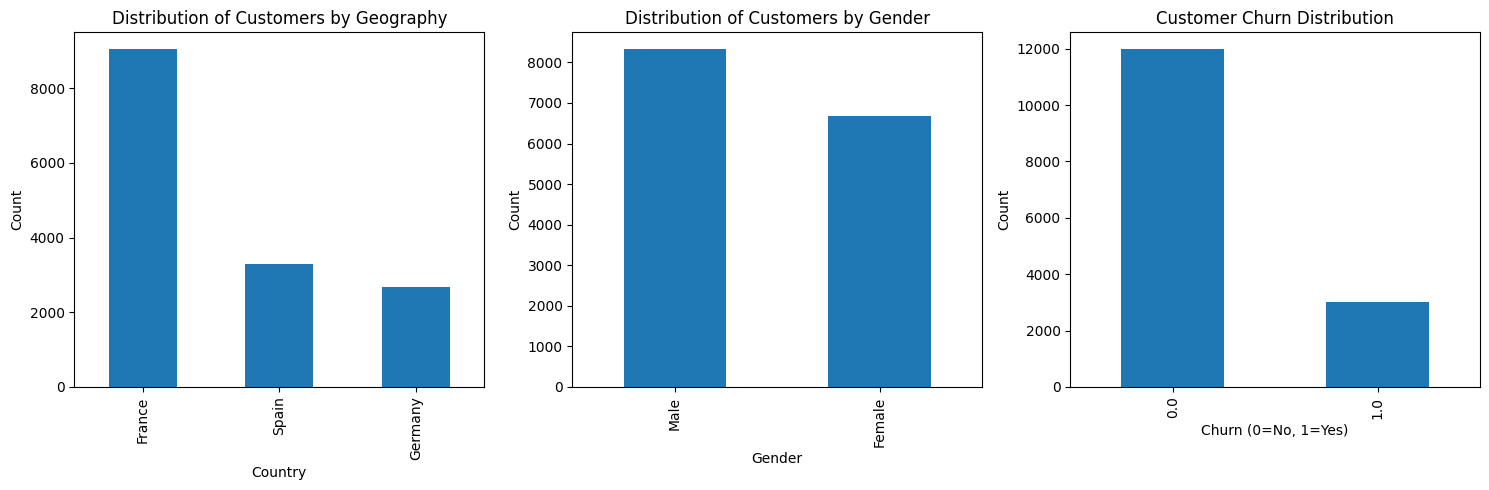

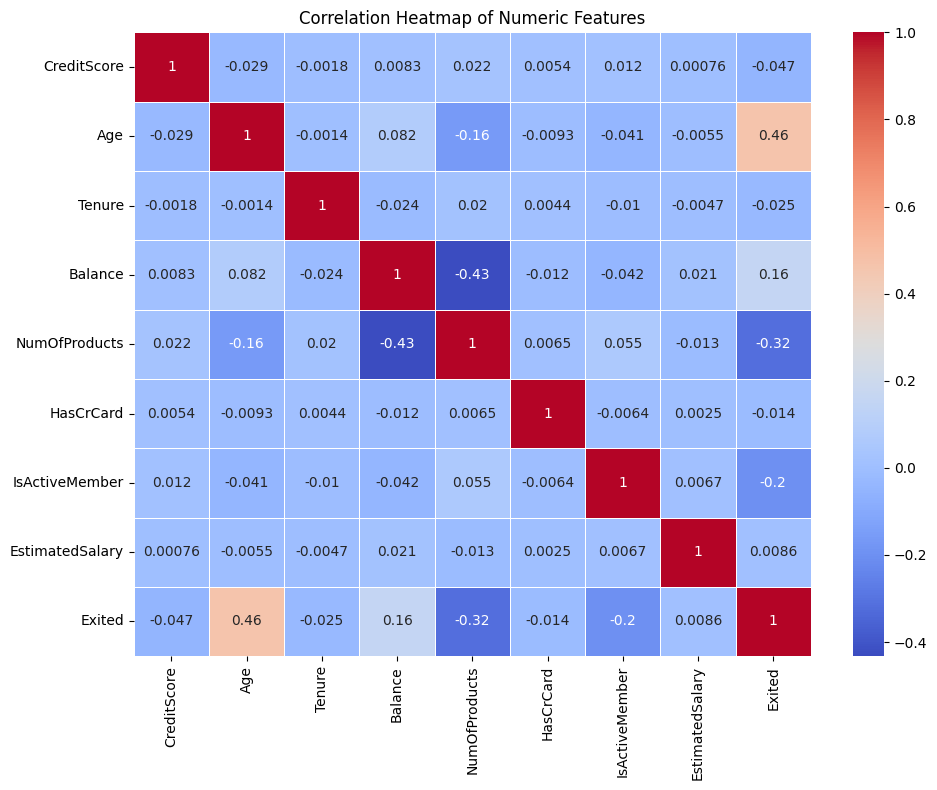

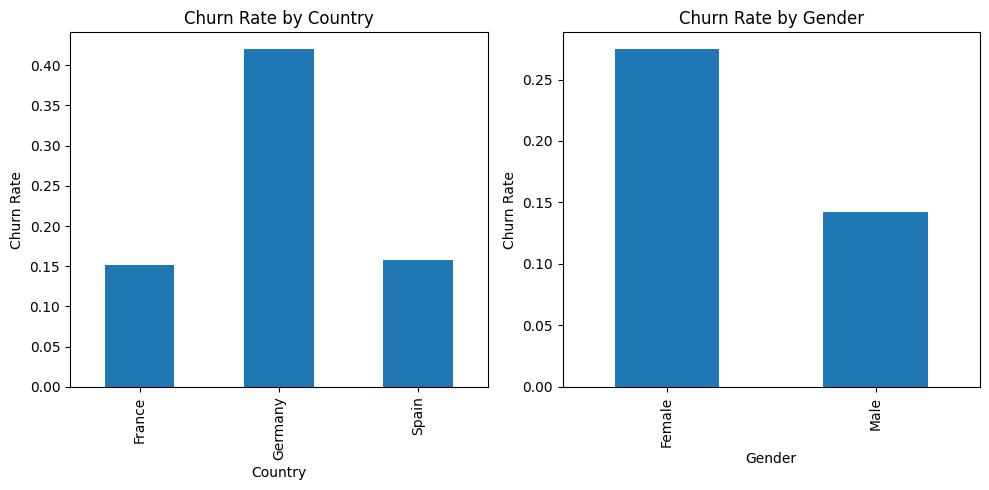

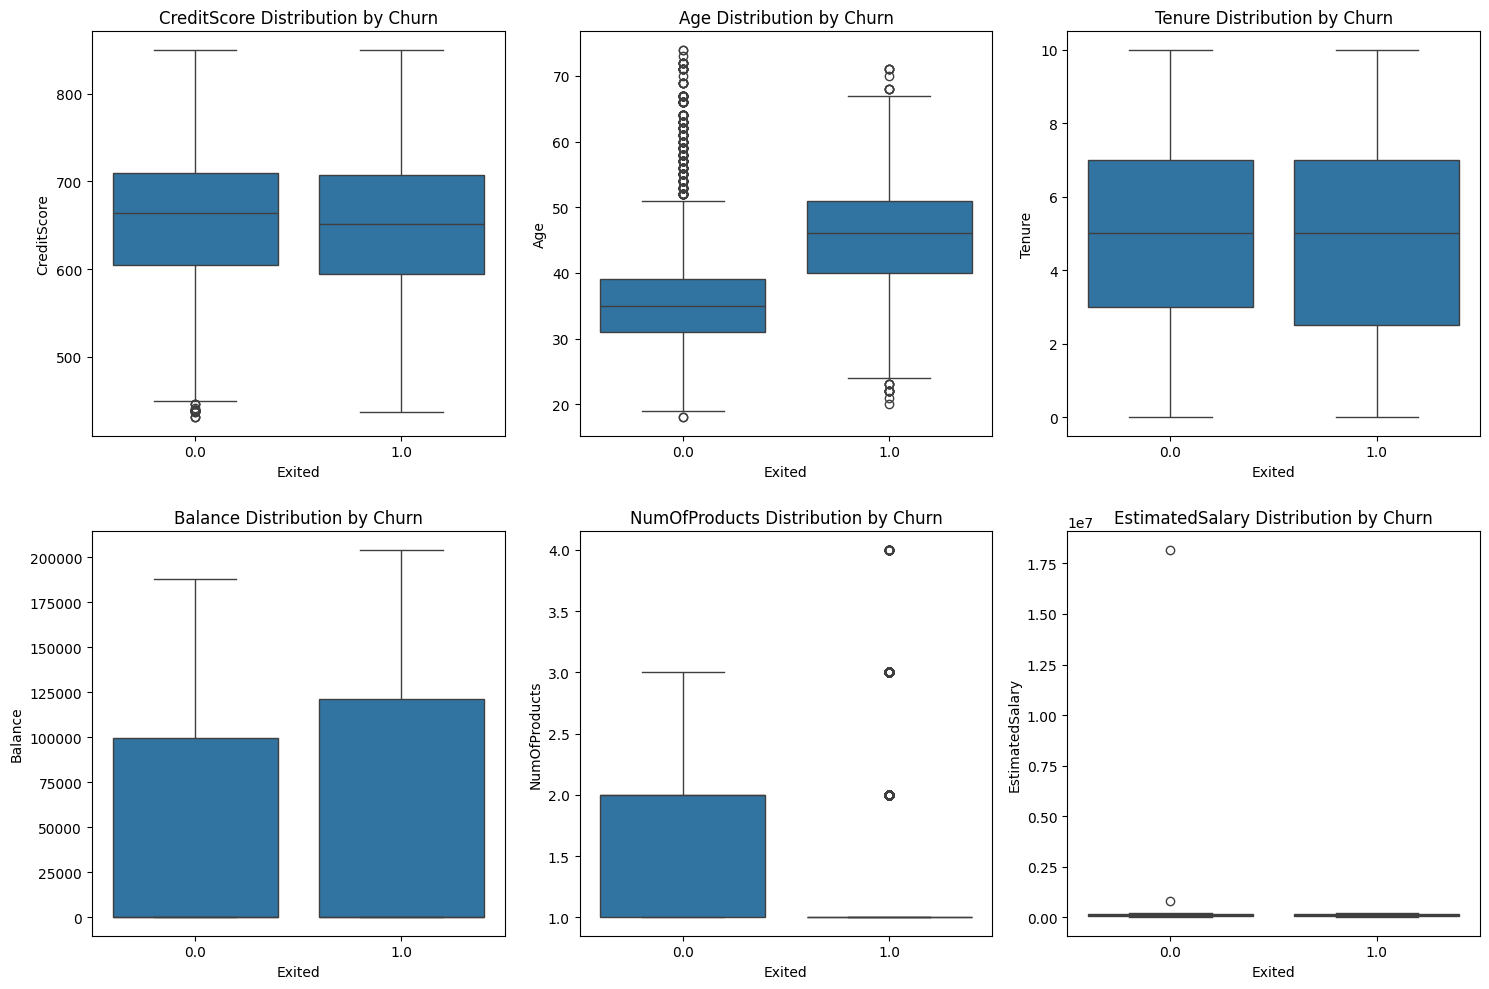

In [14]:
# Categorical variable distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
data['Geography'].value_counts().plot(kind='bar')
plt.title('Distribution of Customers by Geography')
plt.xlabel('Country')
plt.ylabel('Count')

# Gender distribution
plt.subplot(1, 3, 2)
data['Gender'].value_counts().plot(kind='bar')
plt.title('Distribution of Customers by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

# Churn distribution
plt.subplot(1, 3, 3)
data['Exited'].value_counts().plot(kind='bar')
plt.title('Customer Churn Distribution')
plt.xlabel('Churn (0=No, 1=Yes)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

# Churn analysis by geography
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
data.groupby('Geography')['Exited'].mean().plot(kind='bar')
plt.title('Churn Rate by Country')
plt.xlabel('Country')
plt.ylabel('Churn Rate')

# Churn analysis by gender
plt.subplot(1, 2, 2)
data.groupby('Gender')['Exited'].mean().plot(kind='bar')
plt.title('Churn Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Churn Rate')

plt.tight_layout()
plt.show()

# Distribution of key numeric features by churn
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Exited', y=feature, data=data)
    plt.title(f'{feature} Distribution by Churn')

plt.tight_layout()
plt.show()


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(depth=4,iterations=1000,l2_leaf_reg=5,learning_rate=0.01,random_state=42, verbose=0))
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, predictions)
print(f'AUC Score: {auc_score}')


AUC Score: 0.9306505990420586


In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, predictions)
print(f'AUC Score: {auc_score}')


AUC Score: 0.9220837129883885


In [10]:
ids = list(range(15000, 25000))
results_df = pd.DataFrame({
    'id': ids,
    'Exited': (predictions)
})
results_df.to_csv('submission.csv', index=False)

ValueError: All arrays must be of the same length